In [2]:
import os
import pandas as pd 
import matplotlib
from sklearn import linear_model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve, precision_recall_fscore_support
from sklearn.model_selection import train_test_split, StratifiedKFold, LeaveOneOut
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import shap
import seaborn as sns
import itertools as it
from sklearn.feature_selection import RFE
from sklearn.multiclass import OneVsRestClassifier
from sklearn.decomposition import PCA
from openpyxl import Workbook, load_workbook

from openpyxl import Workbook
from openpyxl.drawing.image import Image

sns.set_style("whitegrid")

os.chdir('/lustre/home/reynaj/Projects/20241011.kevin_byrd.ibd_nulisa')
outdir = 'results/specimen_focused/logit_model/cd_versus_uc_only/'

os.makedirs(outdir, exist_ok=True)

# set the random_state
random_state = 17

/lustre/home/reynaj/anaconda3/envs/starter/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load the data

In [5]:
# Load the protein levels data
protein_data = pd.read_csv("results/specimen_focused/comp_data/protein_levels.npq.tsv", sep="\t")
protein_data = protein_data.T

# extract triplet
protein_data = protein_data.loc[:,:]

# Load the clinical data
clinical_data = pd.read_csv("results/specimen_focused/comp_data/clinical_data.tsv", sep="\t")

# remove alamar samples
keep = (~clinical_data['sample_id'].str.contains('SC_Rep')).tolist()
clinical_data = clinical_data.loc[keep,:]
protein_data = protein_data.loc[keep,:]

# extract just CD and UC data
focus_idxs = np.argwhere(clinical_data['ibd_diagnosis'].isin(['CD', 'UC'])).reshape(-1)
# clinical_data = clinical_data.iloc[focus_idxs]
protein_data = protein_data.iloc[focus_idxs, :]

In [6]:
protein_data.head()

,AGER,AGRP,ANGPT1,ANGPT2,ANXA1,AREG,BDNF,BMP7,BST2,C1QA,...,TREM2,TSLP,VCAM1,VEGFA,VEGFC,VEGFD,VSNL1,VSTM1,WNT16,WNT7A
TRP-34082,5.493463,8.765074,15.76212,11.250206,17.79754,14.68076,0.000000,7.512066,10.206268,8.081331,...,6.206720,10.94101,0.000000,18.23954,16.68403,9.214276,22.58694,14.75831,7.103437,8.497241
TRP-34086,4.453723,10.299592,17.59438,11.835780,16.49940,14.91346,9.248813,9.961362,11.179836,8.589964,...,0.000000,11.29018,7.094106,18.36369,19.17019,8.799946,20.19290,17.99542,7.941584,8.232622
TRP-42335,6.469100,11.617355,17.49572,12.059989,20.11341,12.85620,0.000000,8.614946,9.096235,9.529024,...,6.516471,11.47073,0.000000,18.52676,18.22880,7.187657,20.12907,17.56549,5.531130,5.503245
TRP-42324,5.398481,8.084902,18.85520,11.783576,20.28382,13.00942,0.000000,8.196127,10.835604,0.000000,...,5.131593,11.29977,0.000000,18.23974,17.62960,8.247575,20.06370,17.24266,0.000000,8.372645
TRP-42322,5.444545,9.068033,18.69799,12.531015,19.71289,16.21479,0.000000,9.476020,16.270733,10.781654,...,7.467110,11.17309,0.000000,18.78044,18.04191,11.034922,21.84698,17.57186,8.126035,9.796662


In [7]:
clinical_data.head()

,project_name,sample_type,sample_id,collection_date,box_id,box_location,total_volume__ml,original_subject_id,event_name,ibd_diagnosis,date_collection,disease_activity,matched_subject_id,notes,ibd_indicator,disease_activity_indicator,max_crp_value,crp_severity
0,Byrd_IBD_Saliva_sup,Saliva,TRP-34082,2023-11-30 15:34:05.854,1.0,A1,1100.0,TRP-34082,1.0,CD,2023-11-30,Quiescent,1.0,NaN,IBD Super Group,In-active Disease,1.0,Mild
1,Byrd_IBD_Saliva_sup,Saliva,TRP-34086,2023-11-30 15:34:05.854,1.0,A2,1100.0,TRP-34086,1.0,CD,2023-11-30,Quiescent,3.0,NaN,IBD Super Group,In-active Disease,1.0,Mild
2,Byrd_IBD_Saliva_sup,Saliva,TRP-42335,2023-12-20 16:51:00.779,1.0,A3,1000.0,TRP-42335,1.0,CD,2023-12-20,Quiescent,7.0,NaN,IBD Super Group,In-active Disease,1.0,Mild
3,Byrd_IBD_Saliva_sup,Saliva,TRP-42324,2023-12-20 13:54:07.467,1.0,A4,1000.0,TRP-42324,1.0,UC,2023-12-20,Quiescent,6.0,NaN,IBD Super Group,In-active Disease,9.0,Moderate
4,Byrd_IBD_Saliva_sup,Saliva,TRP-42322,2023-12-20 13:53:28.319,1.0,A5,1000.0,TRP-42322,1.0,CD,2023-12-20,Quiescent,5.0,NaN,IBD Super Group,In-active Disease,1.0,Mild


In [8]:
clinical_data.loc[clinical_data['matched_subject_id'] == 20]

,project_name,sample_type,sample_id,collection_date,box_id,box_location,total_volume__ml,original_subject_id,event_name,ibd_diagnosis,date_collection,disease_activity,matched_subject_id,notes,ibd_indicator,disease_activity_indicator,max_crp_value,crp_severity
17,Byrd_IBD_Saliva_sup,Saliva,TRP-42641-1,2024-01-31 15:51:44.24,1.0,B8,1500.0,TRP-42641-1,1.0,IBD-U,2024-01-31,Quiescent,20.0,NaN,IBD Super Group,In-active Disease,5.0,Moderate
53,Byrd_IBD_Saliva_sup,Saliva,TRP-45553-1,2024-03-27 15:51:34.595,1.0,F4,1000.0,TRP-45553-1,2.0,IBD-U,2024-03-27,Moderate,20.0,NaN,IBD Super Group,Active Disease,5.0,Moderate


In [5]:
# load the model results
fn = os.path.join(outdir, 'logit_model.rfe_16_proteins.coefs.xlsx')
logit_model_coefs = pd.read_excel(fn)
selected_features_list = logit_model_coefs.protein.tolist()

In [6]:
# load the leave one out results
fn = os.path.join(outdir, 'leave_one_out_validation.rfe16.tsv')
results_loo_df = pd.read_table(fn)

### Diving into 7 incorrect samples using PCA with all features

In [7]:
tdf = results_loo_df.copy()
tdf.index = protein_data.index.tolist()
full_data = pd.concat([protein_data, tdf], axis=1)

# extract incorrect samples
incorrect_data = full_data.loc[full_data['match'] == False]

In [8]:
# Run PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(protein_data)
principal_components = pca.fit_transform(protein_data.loc[:, selected_features_list])

# make into a dataframe
principal_components = pd.DataFrame(principal_components, columns=['pc1', 'pc2'])

# add the index
principal_components.index = protein_data.index.tolist()

# add the subject id
principal_components['matched_subject_id'] = clinical_data.matched_subject_id.astype(str).values.tolist()

# add prediction information
principal_components['matched_predictions'] = results_loo_df['match'].values.tolist()

# add subject error color depending on subjects that have at least one messed up sample
subject_with_errs = principal_components.groupby('matched_subject_id').matched_predictions.apply(lambda v: (~v).sum())
subject_with_errs = subject_with_errs[subject_with_errs > 0] 
principal_components['subject_err_color'] = principal_components.matched_subject_id.apply(lambda x: x if x in subject_with_errs.index.tolist() else 'other')

In [9]:
# get the error subjects and their counts for number of samples
subjects_with_err = principal_components[principal_components.matched_subject_id.isin(subject_with_errs.index.tolist())].matched_subject_id.value_counts()
subjects_with_err = subjects_with_err.to_frame()
subjects_with_err.sort_values('matched_subject_id', key=lambda vals: [float(v) for v in vals])

,count
matched_subject_id,
1.0,1
8.0,2
9.0,4
39.0,1
44.0,1
52.0,1
63.0,1


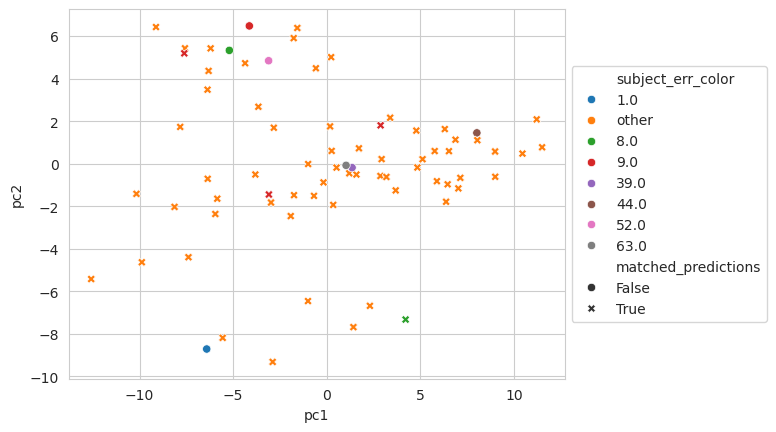

In [10]:
# Create a scatter plot of the PCA results
fig, ax = plt.subplots()
sns.scatterplot(x='pc1', y='pc2', hue='subject_err_color', style='matched_predictions', data=principal_components, ax=ax)

# Place the legend outside the plot
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

outfn = os.path.join(outdir, 'pca.with_selected_features.rfe16.svg')
fig.savefig(outfn)

### Merge the data for manual investigation

In [54]:
samples_with_annot = principal_components.merge(clinical_data, left_index=True, right_on='original_subject_id', suffixes=(None, '_y'))
samples_with_annot = samples_with_annot.iloc[:, ~samples_with_annot.columns.str.contains('_y$')]

cols = ['matched_subject_id', 'sample_id', 'subject_err_color', 'matched_predictions', 'pc1', 'pc2', 'project_name',
        'sample_type', 'collection_date', 'box_id', 'box_location', 'total_volume__ml', 'original_subject_id',
        'event_name', 'ibd_diagnosis', 'date_collection', 'disease_activity', 'notes', 'ibd_indicator',
        'disease_activity_indicator', 'max_crp_value', 'crp_severity']
samples_with_annot = samples_with_annot.loc[:, cols]
samples_with_annot = samples_with_annot.sort_values(['matched_subject_id', 'sample_id', 'matched_predictions'])

In [56]:
outfn = os.path.join(outdir, 'sample_predictions_with_annotations.xlsx')
samples_with_annot.to_excel(outfn, index=False)

### PCA with colors for various categorical vars

To be continued...

### Correlation samples to one another using 16 RFE variables

In [11]:
# calculate the correlation between samples
subject_corrs = protein_data.loc[:, selected_features_list].transpose().corr()

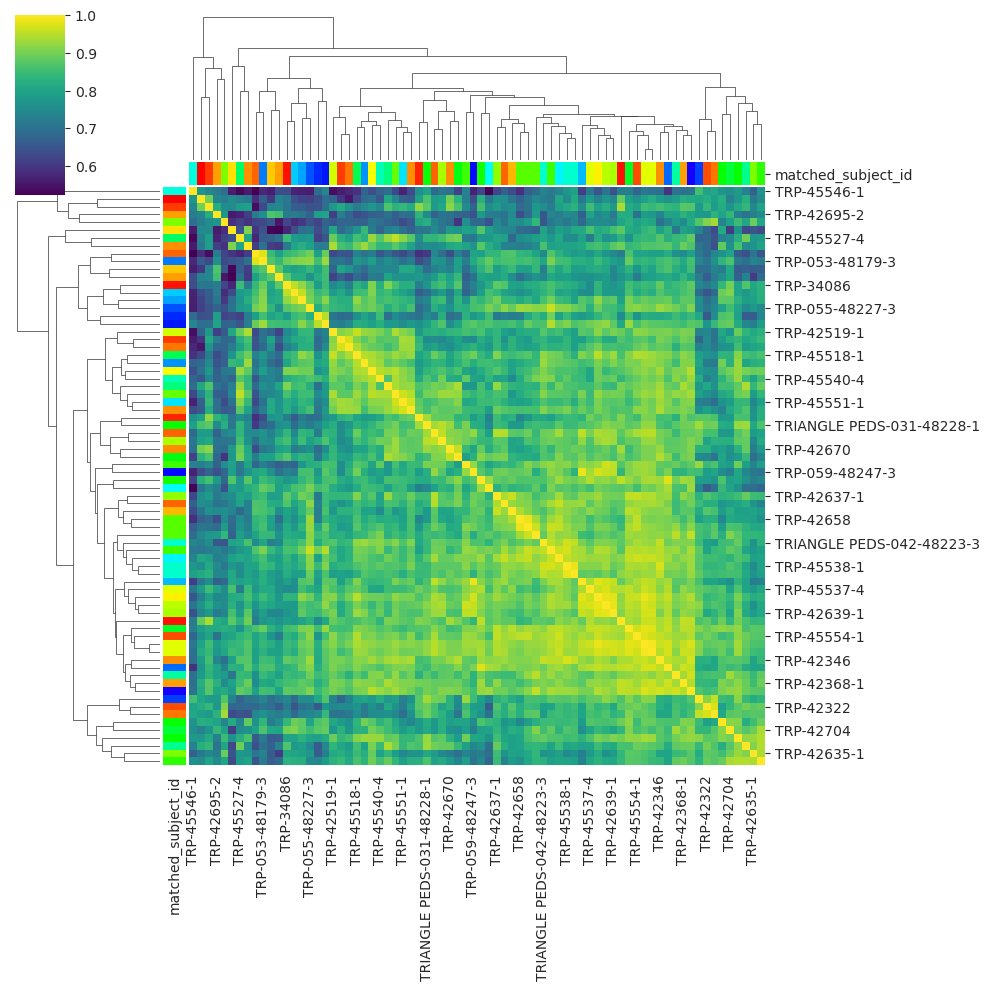

In [12]:
# assign colors to columns
# add color to each subject
nsubjects = subject_corrs.shape[0]
cmap = plt.colormaps['hsv']
hex_colors = [mcolors.rgb2hex(cmap(i/nsubjects)) for i in range(nsubjects)]
colors_dict = dict(zip(principal_components['matched_subject_id'].unique(), hex_colors))
colors_for_cols = principal_components['matched_subject_id'].map(colors_dict)

# make the clustermap
cg = sns.clustermap(subject_corrs, method='average', cmap='viridis', col_colors=colors_for_cols, row_colors=colors_for_cols)

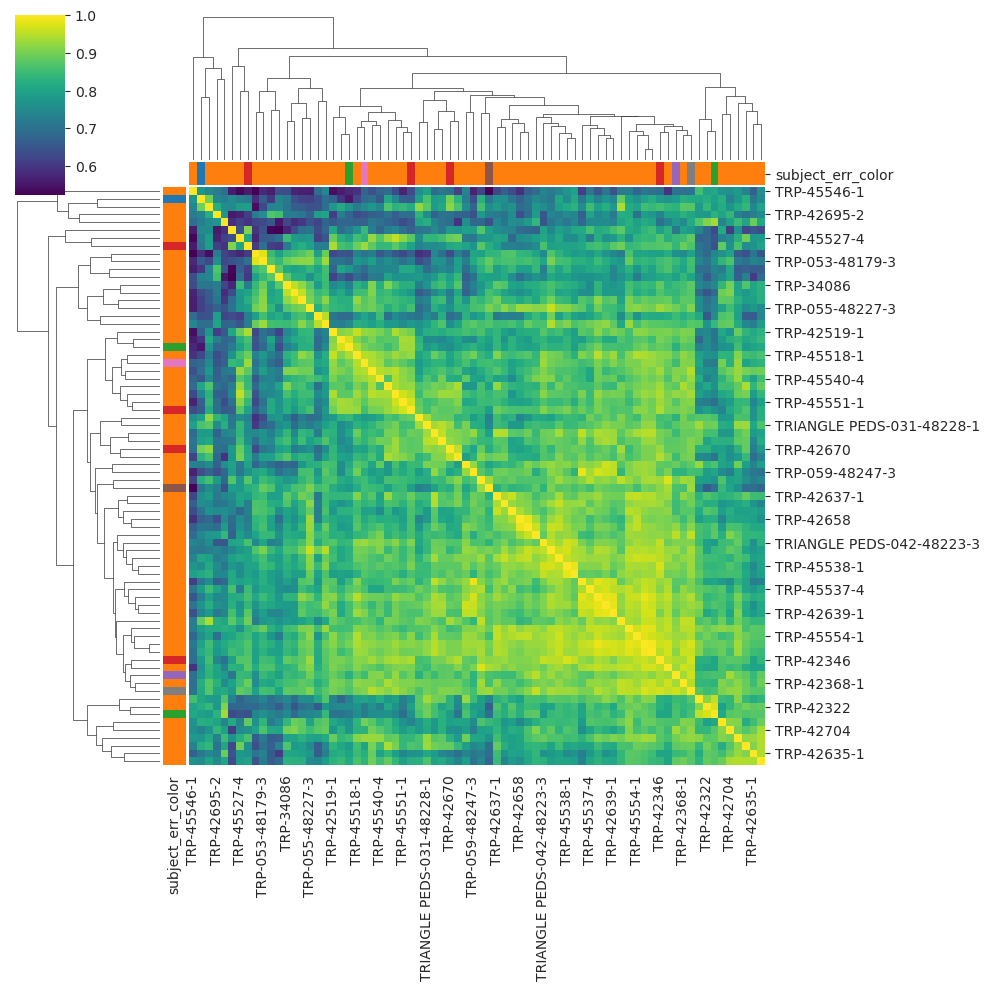

In [13]:
# calculate the correlation between samples
subject_corrs = protein_data.loc[:, selected_features_list].transpose().corr()

# assign colors to columns
subject_err_to_color = principal_components['subject_err_color'].unique()
colors = sns.color_palette().as_hex()
colors_dict = dict(zip(subject_err_to_color, colors))
colors_for_cols = principal_components['subject_err_color'].map(colors_dict)

# make the clustermap
cg = sns.clustermap(subject_corrs, method='average', cmap='viridis', col_colors=colors_for_cols, row_colors=colors_for_cols)


### Correlation samples to one another using all proteins

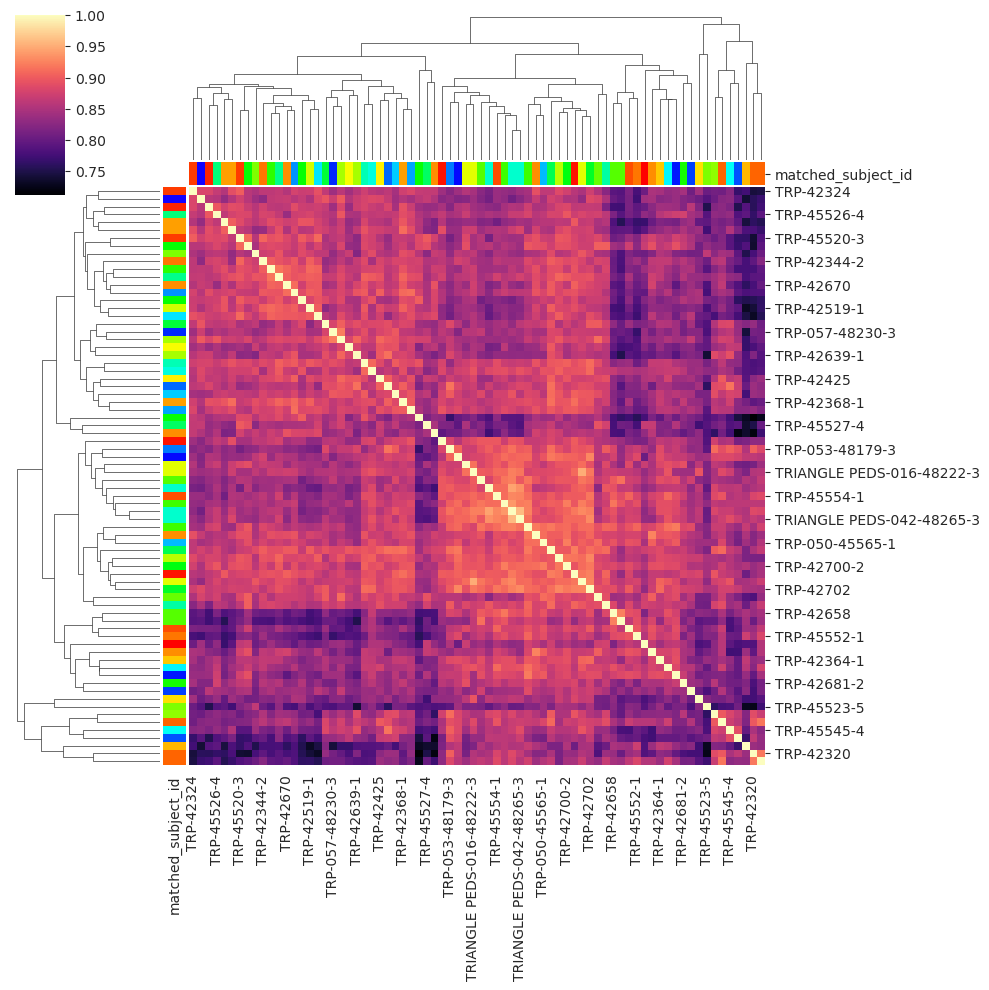

In [14]:
# calculate the correlation between samples
subject_corrs = protein_data.transpose().corr()

# assign colors to columns
# add color to each subject
nsubjects = principal_components.shape[0]
cmap = plt.colormaps['hsv']
hex_colors = [mcolors.rgb2hex(cmap(i/nsubjects)) for i in range(nsubjects)]
colors_dict = dict(zip(principal_components['matched_subject_id'].unique(), hex_colors))
colors_for_cols = principal_components['matched_subject_id'].map(colors_dict)

# make the clustermap
cg = sns.clustermap(subject_corrs, method='average', cmap='magma', col_colors=colors_for_cols, row_colors=colors_for_cols)

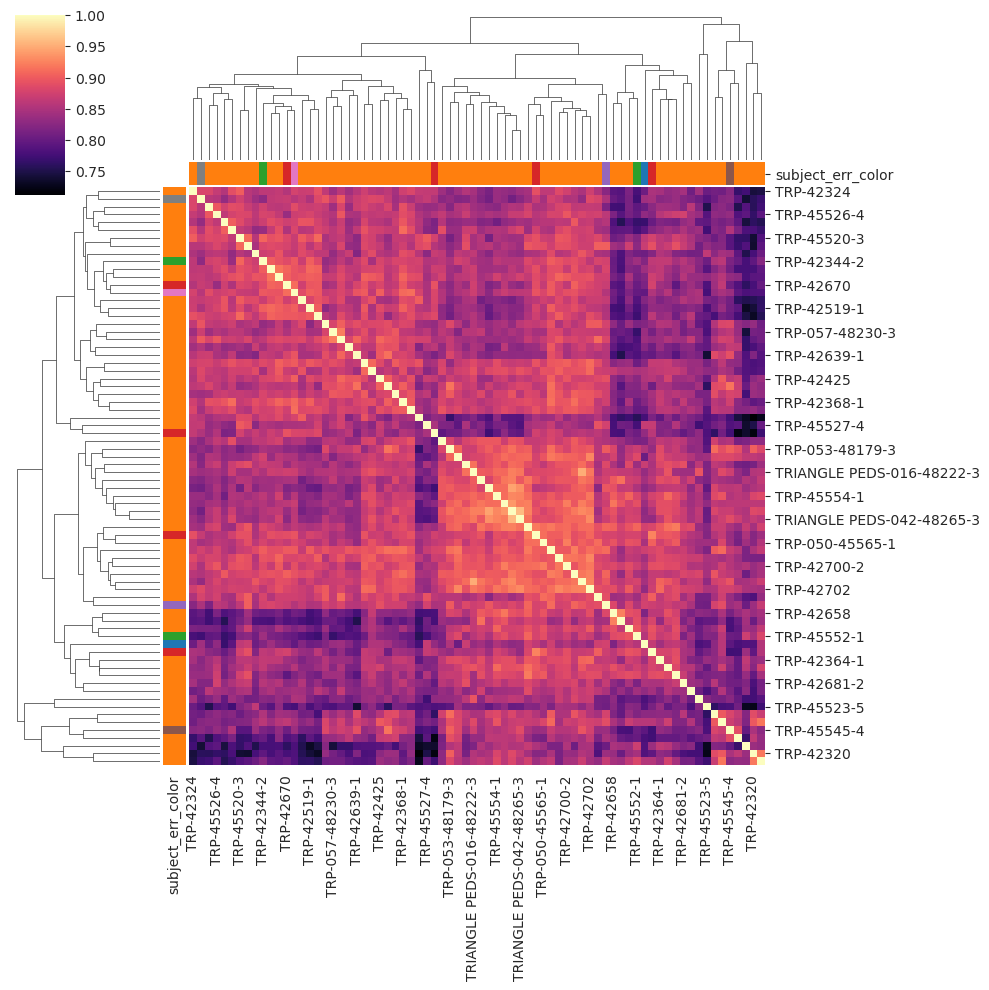

In [15]:
# calculate the correlation between samples
subject_corrs = protein_data.transpose().corr()

# assign colors to columns
subject_err_to_color = principal_components['subject_err_color'].unique()
colors = sns.color_palette().as_hex()
colors_dict = dict(zip(subject_err_to_color, colors))
colors_for_cols = principal_components['subject_err_color'].map(colors_dict)

# make the clustermap
cg = sns.clustermap(subject_corrs, method='average', cmap='magma', col_colors=colors_for_cols, row_colors=colors_for_cols)

### Correlate RFE variables to CRP Values

In [16]:
import scipy.stats as stats

In [17]:
crp_corrs = []
bool_mask = (~clinical_data.max_crp_value.isna()).tolist()
y = clinical_data.loc[bool_mask, 'max_crp_value']
for prot in selected_features_list:
    x = protein_data.loc[bool_mask, prot].values.tolist()
    corr_coef, p_value = stats.pearsonr(x, y)
    crp_corrs.append([prot, corr_coef])

In [18]:
crp_corrs_df = pd.DataFrame(crp_corrs, columns=['protein', 'R'])

In [19]:
crp_corrs_df

,protein,R
0,IL17RB,0.081771
1,FGF23,-0.033446
2,PDCD1LG2,-0.278577
3,CD83,-0.136211
4,GZMA,0.124276
5,CCL2,0.351191
6,CST7,0.180147
7,IL34,0.019360
8,GFAP,0.062142
9,TNFRSF4,-0.215114
